[Home](index.ipynb) > [Data Transformation](data_transformation.ipynb) > Meaning structures

<img style='float: left;' src='https://www.gesis.org/fileadmin/styles/img/gs_home_logo_en.svg'>

### ``compsoc`` – *Notebooks for Computational Sociology* (alpha)

# Meaning structures: Bipartite matrix projection
Authors: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

Version: 0.91 (14.09.2020)

Please cite as: Lietz, Haiko (2020). Meaning structures: Bipartite matrix projection. Version 0.91 (14.09.2020). *compsoc – Notebooks for Computational Sociology*. GESIS. url:[github.com/gesiscss/compsoc](https://github.com/gesiscss/compsoc)

<div class='alert alert-info'>
<big><b>Significance</b></big>

Bla.
</div>

## Introduction
According to the model of complex socio-cultural systems sketched in the introduction, transactions resemble the building blocks of these systems. From all the transactions in a field, a patterned macrobehavior emerges that provides expectations or meaning for future microbehavior. We refer to such structures as meaning structures (Mohr, xxxx). To get a grip on this concept, we mapped the systems model to a unified model for digital behavioral data. The fundamental idea is that agents make transactions and transactions select facts. The latter notion expresses the duality that a selection is both a top-down and a bottom-up hypothesis. In downward causation, selection expresses how agents are influenced by emergent facts -- in Padgett & Powell's (2012) words, "relations make actors"; as part of emergence, selection expresses how agents are free to chose facts -- "actors make relations".

... Social and cultural meaning structures ... agency

White's market profiles

cores... Fuchs

Flack's power distributions

Zipf's Law

communities and blocks

catalysis

attention economics

Breiger

domains... types of tie

|<img src='images/lietz_2020_fig2.png' style='float: none; width: 500px'>|
|:--|
|<em style='float: center'>**Figure 1**: Mapping of socio-cultural systems model to mathematical framework (fig. 2 in Lietz, 2020)</em>|

**In this notebook**, we demonstrate how we can use the unified data model to study the meaning encoded in networks. We will lay out a core part of the ``compsoc`` mathematical framework (figure 1). We will see how digital behavioral data can be naturally represented by bipartite matrices, how meaning structures can be obtained by projecting these matrices, how matrix normalization can be used to account for potential behavioral differences in subfields, and how matrix algebra and community detection go hand in hand to uncover multiple layers or domains of social life from data. Two basic functions will be developed. They are largely based on the mathematical framework developed by Batagelj and Cerinšek (2013). Lietz (2020, particularly the [technical appendix](https://link.springer.com/article/10.1007/s11192-020-03527-0#appendices)) can be read to gain traction on the formalism used in this notebook. To be able to process large data collections, this notebook uses sparse matrix methods.

## Dependencies and settings

In [1]:
import compsoc as cs
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
#import warnings

In [3]:
#warnings.filterwarnings('ignore')

## Understanding the basic formalism
A simple toy model shall help us to keep things simple and understandable. It contains only the most central aspects of transactions selecting facts and transactions belonging to domains:

|<img src='images/data_model_toy.png' style='float: none; width: 380px'>|
|:--|
|<em style='float: center'>**Figure 2**: Subset of unified model for digital behavioral data</em>|

The data, depicted in figure 1, resembles a field that consists of $m=5$ distinct transactions. Our computational framework requires that identifiers are integers from $0$ to $m-1$. Transactions are stored in a pandas dataframe:

In [4]:
transactions = [[0, '1', 0], [1, '2', 0], [2, '3', 1], [3, '4', 1], [4, '5', 1]]
transactions = pd.DataFrame(transactions, columns=['transaction_id', 'transaction', 'domain_id'])
transactions

,transaction_id,transaction,domain_id
0,0,1,0
1,1,2,0
2,2,3,1
3,3,4,1
4,4,5,1


In this field, $n=9$ distinct facts are selected:

In [5]:
facts = [[0, '1'], [1, '2'], [2, '3'], [3, '4'], [4, '5'], [5, '6'], [6, '7'], [7, '8'], [8, '9']]
facts = pd.DataFrame(facts, columns=['fact_id', 'fact'])
facts

,fact_id,fact
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,7
7,7,8
8,8,9


Finally, there are $15$ selections. Note that all transactions select a different number of overlapping facts; in the transaction with ``transaction_id=0``, five facts are selected; ``transaction_id=1`` selects four facts; etc.:

In [6]:
#selections = [[0, 0, 1], [0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
selections = [[0, 0, 1], [0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1], [1, 5, 1], [2, 4, 1], [2, 5, 1], [2, 6, 1], [3, 6, 1], [3, 7, 1], [4, 8, 1]]
selections = pd.DataFrame(selections, columns=['transaction_id', 'fact_id', 'weight'])
selections

,transaction_id,fact_id,weight
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,1,2,1
6,1,3,1
7,1,4,1
8,1,5,1
9,2,4,1


The ``selections`` dataframe contains all the information we need to create the bipartite **selection matrix** $G$. Since all transaction and fact identifiers are present, $G$ is an $m\times n$ matrix where ``weight`` gives the strength or number of times that a transaction is selecting a fact.

We use the ``scipy.sparse`` package to handle matrices. It uses different formats to store information that have advantages and drawback for certain tasks. For matrix construction, the [COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) format is intended:

In [7]:
from scipy.sparse import csr_matrix, coo_matrix, triu

In [8]:
rows = selections['transaction_id'].tolist()
columns = selections['fact_id'].tolist()
cells = selections['weight'].tolist()

In [9]:
G = coo_matrix((cells, (rows, columns)))

In [10]:
type(G)

scipy.sparse.coo.coo_matrix

Technical summary of the matrix:

In [11]:
G.__dict__

{'_shape': (5, 9),
 'maxprint': 50,
 'row': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4], dtype=int32),
 'col': array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32),
 'data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'has_canonical_format': False}

Easy-to-read summary:

In [12]:
print(G)

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (2, 4)	1
  (2, 5)	1
  (2, 6)	1
  (3, 6)	1
  (3, 7)	1
  (4, 8)	1


Row indices of selections can be accessed like this:

In [13]:
G.nonzero()[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4], dtype=int32)

Column indices of selections can be accessed like this:

In [14]:
G.nonzero()[1]

array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32)

Weights of selections can be accessed like this:

In [15]:
G.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Finally, a sparse matrix can be transformed into a dense array like this:

In [16]:
G.toarray()

array([[1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

### Matrix normalization
Consider an academic field where transactions are publications, selections are citations, and facts are the references cited in a puplication. Further consider that the field is interdisciplinary: authors from one discipline cite 10 references on average, authors from another discipline cite 20 references on average. Intuitively, a reference that receives one citation out of 10 has a larger influence on the publication than one that receives one out of 20. By dividing a citation (selection) by the number of citations (selections) made, this difference can be accounted for. Mathematically, this amounts to a row normalization of the selection matrix $G$. This way of normalizing selections has first been proposed by Leydesdorff and Opthof (2010) for counting citations. Batagelj and Cerinšek (2013) have made it a pillar in their matrix formalism.

For fast row normalization, we first transform $G$ to the [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [17]:
G = G.tocsr()
G.__dict__

{'_shape': (5, 9),
 'maxprint': 50,
 'indices': array([0, 1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 6, 6, 7, 8], dtype=int32),
 'indptr': array([ 0,  5,  9, 12, 14, 15], dtype=int32),
 'data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 '_has_canonical_format': True,
 '_has_sorted_indices': True}

The row-normalized matrix depicted in the middle of figure 1 is called $G^\mathrm{N}$:

In [18]:
from sklearn.preprocessing import normalize

In [19]:
GN = normalize(G, norm='l1', axis=1)

Compare the normalized to the unnormalized selections:

In [20]:
df_selections = pd.DataFrame(G.toarray())
df_selections.index.name = 'transaction_id'
df_selections.columns.name = 'fact_id'
df_selections

fact_id,0,1,2,3,4,5,6,7,8
transaction_id,,,,,,,,,
0,1,1,1,1,1,0,0,0,0
1,0,0,1,1,1,1,0,0,0
2,0,0,0,0,1,1,1,0,0
3,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,1


In [21]:
df_selections = pd.DataFrame(GN.toarray())
df_selections.index.name = 'transaction_id'
df_selections.columns.name = 'fact_id'
df_selections

fact_id,0,1,2,3,4,5,6,7,8
transaction_id,,,,,,,,,
0,0.2,0.2,0.20,0.20,0.200000,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.25,0.25,0.250000,0.250000,0.000000,0.0,0.0
2,0.0,0.0,0.00,0.00,0.333333,0.333333,0.333333,0.0,0.0
3,0.0,0.0,0.00,0.00,0.000000,0.000000,0.500000,0.5,0.0
4,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,1.0


### Matrix projection
The two bold arrows in figure 1 show the two projections that can be obtained via [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication). Projection generally involves multiplications with the transposed selection matrix. The transpose of the selection matrix $G$ is called $G^\mathrm{T}$ and has dimensionality $n\times m$, i.e., the rows (columns) of $G$ are its columns (rows). Similarly, the transpose of the normalized selection matrix $G^\mathrm{N}$ is $(G^\mathrm{N})^\mathrm{T}$.
#### Projection to the transaction mode
The first kind of projection results in transaction similarity matrices:

- $H=G\times G^\mathrm{T}$ is a transaction similarity matrix where weights $x_{ik}\in \mathbb{N}$ are the numbers of facts co-selected by transactions $i$ and $k$;
- $H^\mathrm{N}=G^\mathrm{N}\times(G^\mathrm{N})^\mathrm{T}$ is a normalized transaction similarity matrix where weights $x_{ik}^\mathrm{N}\in \mathbb{R}_{[0,1]}$ are the products of the normalized selections made in transactions $i$ and $k$, summed over all facts  $j$.

$H^\mathrm{N}$ is the complementary transformation of the one described by Batagelj and Cerinšek (2013, section 3.4). Transaction matrices are directed but symmetric. Weights $x_{ik}$ and $x_{ik}^\mathrm{N}$ can be interpreted as transaction similarities.

In [22]:
GT = csr_matrix.transpose(G)
GNT = csr_matrix.transpose(GN)

Note that transposing a matrix in [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format creates a matrix in [Compressed Sparse Column](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) format:

In [23]:
type(GT)

scipy.sparse.csc.csc_matrix

In [24]:
H = G*GT
HN = GN*GNT

The format of a projected matrix is determined by the format of the first factor:

In [25]:
type(HN)

scipy.sparse.csr.csr_matrix

Since weights in transaction matrices can be interpreted as transaction similarities, there is no use in carrying along both triangular portions of the matrix. To remove a portion, transform the matrix into [COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) format, ...

In [26]:
HN = HN.tocoo()

... remove the upper portion (you could just as well use ``tril()`` to remove the lower portion) of the matrix, ...

In [27]:
HN = triu(HN)

... and transform the matrix back into [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [28]:
HN = HN.tocsr()

To draw $H^\mathrm{N}$ as a graph, create an edge list, ...

In [29]:
similarities_norm = pd.concat([
    pd.Series(HN.nonzero()[0]), 
    pd.Series(HN.nonzero()[1]), 
    pd.Series(HN.data)
], axis=1)
similarities_norm.columns = ['transaction_id_from', 'transaction_id_to', 'weight']
similarities_norm

,transaction_id_from,transaction_id_to,weight
0,0,0,0.200000
1,0,1,0.150000
2,0,2,0.066667
3,1,1,0.250000
4,1,2,0.166667
5,2,2,0.333333
6,2,3,0.166667
7,3,3,0.500000
8,4,4,1.000000


... construct the graph using ``compsoc``'s ``construct_graph(directed=False, ...)`` function described here, ...

In [30]:
hn = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='HN', 
    node_list=transactions, 
    edge_list=similarities_norm, 
    node_label='transaction'
)

... and draw the graph using ``compsoc``'s custom ``draw_graph()`` wrapper described here:

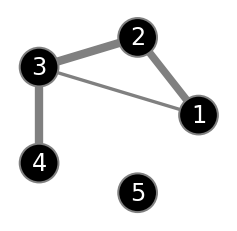

In [31]:
cs.draw_graph(
    hn, 
    node_pos=nx.circular_layout(hn), 
    node_size_factor=.25, 
    node_color=cs.uniform_vertex_property(hn, 'black'), 
    node_border_width=2, 
    edge_width_factor=50, 
    labels='text', 
    font_size_factor=2, 
    font_color='white', 
    figsize='small', 
    margins=.2
)

#### Projection to the fact mode
The second kind of projection results in fact co-selection matrices:

- $I=G^\mathrm{T}\times G$ is a fact co-selection matrix where weights $y_{jl}\in \mathbb{N}$ are the numbers of transactions that co-select facts $j$ and $l$ (Batagelj and Cerinšek 2013, section 3.2);
- $I^\mathrm{N}=G^\mathrm{T}\times G^\mathrm{N}$ is a normalized fact co-selection matrix where weights $y_{jl}^\mathrm{N}\in \mathbb{R}_{\geq0}$ are the normalized numbers of transactions that co-select facts $j$ and $l$ (Batagelj and Cerinšek 2013, section 3.3).

Fact matrices are also directed and symmetric. It is these matrices that resemble **meaning structures**. According to our general model of complex socio-cultural systems, they emerge from the collective transactions in a field, and they harbor the patterns that agents observe and which influence future transactions via downward causation. Co-selection weights $y_{ik}$ and $y_{ik}^\mathrm{N}$ of meaning structures can be interpreted as **catalyses**. Padgett & Powell (2012, chapter 4) have adapted this concept from chemistry to mean that the selection of a product in a social network entails – or makes more likely – the selection of another product (which results in a self-sustaining production cycle). Co-selection is mutual catalysis because the selection of a fact makes the selection of a co-selected fact more likely.

In [32]:
I = GT*G
IN = GT*GN

To correctly access indices and weights, co-selection matrices must be transformed from [Compressed Sparse Column](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) to [Compressed Sparse Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format:

In [33]:
I = I.tocsr()
IN = IN.tocsr()

Transform $I^\mathrm{N}$ to an edge list:

In [34]:
co_selections_norm = pd.concat([
    pd.Series(IN.nonzero()[0]), 
    pd.Series(IN.nonzero()[1]), 
    pd.Series(IN.data)
], axis=1)
co_selections_norm.columns = ['fact_id_from', 'fact_id_to', 'weight']
co_selections_norm.head()

,fact_id_from,fact_id_to,weight
0,0,0,0.2
1,0,1,0.2
2,0,2,0.2
3,0,3,0.2
4,0,4,0.2


For the purpose of illustrating co-selections as mutual catalyses, set ``directed=True``:

In [35]:
_in = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='IN', 
    node_list=facts, 
    edge_list=co_selections_norm, 
    node_label='fact'
)

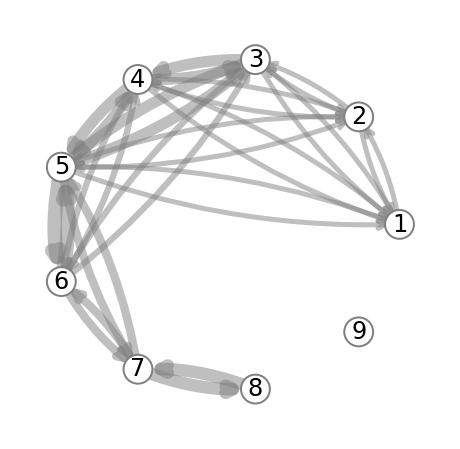

In [36]:
cs.draw_graph(
    _in, 
    node_pos=nx.circular_layout(_in), 
    node_size_factor=.25, 
    node_border_width=2, 
    edge_width_factor=25, 
    edge_transparency=.5, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=2, 
    figsize='medium'
)

### Data enrichment
Normalized fact co-selection matrices $I^\mathrm{N}$ are additive, i.e., fact co-selections from additional transactions can simply be added to existing co-selection weights. Due to this nature, these matrices have a number of unique properties.

The sum of all weights equals the sum of all weights in $G$:

In [37]:
IN.sum()

15.0

#### Fact attributes
The summed **weight** of rows or columns in $I^\mathrm{N}$, i.e., the weighted in- or outdegree $w$ in the corresponding graph, equals the weighted number of selections per fact in the selection matrix $G$. Fact 5 (``fact_id=4``) has been selected most oftern:

In [38]:
w = IN.sum(axis=1)
w = np.squeeze(np.array(w))
w = pd.Series(w).round(4)
w

0    1.0
1    1.0
2    2.0
3    2.0
4    3.0
5    2.0
6    2.0
7    1.0
8    1.0
dtype: float64

Elements in the diagonal $d$ are a measure of how strongly, in absolute terms, the respective facts are **autocatalytic** or catalyze themselves. In our toy example, e.g., transaction 1 selects each of its five facts with a normalized weight of 0.2. Projection of just these five selections to the fact mode would result in a fully connected graph in which facts mutually catalyze each other (including themselves) with a weight of 0.2. Since fact 1 (``fact_id=0``) is not selected in any other transaction, 0.2 is also its final value of autocatalysis, stored in the matrix diagonal. While fact 5 has been selected most often, fact 9 (``fact_id=8``) ist most autocatalytic because it is not co-selected with any other fact:

In [39]:
a = np.array(IN.diagonal())
a = pd.Series(a).round(4)
a

0    0.2000
1    0.2000
2    0.4500
3    0.4500
4    0.7833
5    0.5833
6    0.8333
7    0.5000
8    1.0000
dtype: float64

The fraction of autocatalyses $a$ among all weighted selections $w$ can be turned into a measure of **embeddedness**, $e=1-a/w$. Here, embeddedness basically tells to what extent facts are co-selected. Facts 1 and 2 are most embedded because they are each co-selected among four other facts. Fact 5 is not embedded because it is not co-selected:

In [40]:
e = (1-a/w).round(4)
e

0    0.8000
1    0.8000
2    0.7750
3    0.7750
4    0.7389
5    0.7084
6    0.5834
7    0.5000
8    0.0000
dtype: float64

To compute facts' distinct co-selections or **degrees**, autocatalyses (loops) must be removed. This change of the sparsity structure is fastest using the [LInked List](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) matrix format:

In [41]:
IN_nodiag = IN.tolil()
IN_nodiag.setdiag(values=0)
IN_nodiag.__dict__

{'_shape': (9, 9),
 'maxprint': 50,
 'dtype': dtype('float64'),
 'rows': array([list([1, 2, 3, 4]), list([0, 2, 3, 4]), list([0, 1, 3, 4, 5]),
        list([0, 1, 2, 4, 5]), list([0, 1, 2, 3, 5, 6]),
        list([2, 3, 4, 6]), list([4, 5, 7]), list([6]), list([])],
       dtype=object),
 'data': array([list([0.2, 0.2, 0.2, 0.2]), list([0.2, 0.2, 0.2, 0.2]),
        list([0.2, 0.2, 0.45, 0.45, 0.25]),
        list([0.2, 0.2, 0.45, 0.45, 0.25]),
        list([0.2, 0.2, 0.45, 0.45, 0.5833333333333333, 0.3333333333333333]),
        list([0.25, 0.25, 0.5833333333333333, 0.3333333333333333]),
        list([0.3333333333333333, 0.3333333333333333, 0.5]), list([0.5]),
        list([])], dtype=object)}

With a degree of 6, fact 5 is most strongly connected to other facts:

In [42]:
k = [len(i) for i in IN_nodiag.data.tolist()]
k = pd.Series(k)
k

0    4
1    4
2    5
3    5
4    6
5    4
6    3
7    1
8    0
dtype: int64

A final score is most intuitive when facts are persons but also applies to cultural entities. A person that only goes to few parties but talks to many persons during those transactions may be called sociable. **Sociability** is the extent to which activity (measured as the number of selections $w$) is turned into connections $k$. Facts 1 and 2 are most sociable because one selection each results in four co-selections. Fact 5 is only moderately sociable because it took three selections to obtain six co-selections.

In [43]:
s = (k/w).round(4)
s

0    4.0
1    4.0
2    2.5
3    2.5
4    2.0
5    2.0
6    1.5
7    1.0
8    0.0
dtype: float64

With these fact attributes, we can now enrich the ``facts`` dataframe:

In [44]:
facts_enriched = pd.concat([facts, k, w, a, e, s], axis=1)
facts_enriched.columns = ['fact_id', 'fact', 'degree', 'weight', 'autocatalysis', 'embeddedness', 'sociability']
facts_enriched

,fact_id,fact,degree,weight,autocatalysis,embeddedness,sociability
0,0,1,4,1.0,0.2000,0.8000,4.0
1,1,2,4,1.0,0.2000,0.8000,4.0
2,2,3,5,2.0,0.4500,0.7750,2.5
3,3,4,5,2.0,0.4500,0.7750,2.5
4,4,5,6,3.0,0.7833,0.7389,2.0
5,5,6,4,2.0,0.5833,0.7084,2.0
6,6,7,3,2.0,0.8333,0.5834,1.5
7,7,8,1,1.0,0.5000,0.5000,1.0
8,8,9,0,1.0,1.0000,0.0000,0.0


<div class='alert alert-warning'>
<big><b>Caution</b></big>

It is important to understand the effects of matrix normalization as we have discussed it so far. For example, a strong co-selection of two facts can result from few transactions in which few facts are co-selected or from many transactions in which many facts are co-selected. Matrix normalization complicates interpretability when the number of selections per transaction exhibits large variance. In small-data settings, it may therefore be advised to not use matrix normalization. In big-data settings, it may be possible to remove outlier transactions with exceptionally many selections (e.g., publications with either very short or very long reference lists).
</div>

#### Cumulative co-selection fractions
Sometimes it is can be helpful to filter graphs, e.g., to uncover a pattern that may otherwise be hidden in relational "noise". An observer of a meaning structure may neglect weak ties to identify the core facts of the field. Hence, removing weakly selected nodes or edges is not only a step we can do as network analysts, but an analytical step towards understanding what an observer in a field may have observed as he or she was trying to reduce uncertainty.

As an alternative to simply filtering edges with small weights, one can keep those co-selections that collectively account for a specified amount of attention in the field. For this purpose we enrich edges by **cumulative fractions** of total matrix weights.

First, distinct edge weights and the weight (attention) they collectively account for are identified. In the toy example, a single co-selection tie with a ``weight == 1`` also accounts for a total weight of 1. But 16 co-selection ties with ``weight == 0.2`` account for a total weight of 3.2:

In [45]:
co_selections_norm_cumfrac = co_selections_norm.copy()
co_selections_norm_cumfrac.index = co_selections_norm_cumfrac.weight
co_selections_norm_cumfrac = co_selections_norm_cumfrac['weight'].groupby(co_selections_norm_cumfrac.index).sum()
co_selections_norm_cumfrac = co_selections_norm_cumfrac.sort_index(ascending=False)
co_selections_norm_cumfrac

weight
1.000000    1.000000
0.833333    0.833333
0.783333    0.783333
0.583333    1.750000
0.500000    1.500000
0.450000    3.600000
0.333333    1.333333
0.250000    1.000000
0.200000    3.200000
Name: weight, dtype: float64

Second, the summed weights are turned into cumulative co-selection fractions ``cumfrac`` such that all weights at least as strong as the smallest one account for 100 percent of the attention in the whole field. In the toy example, if we wanted to keep those co-selections that account for no more than 75 percent of the attention (``cumfrac <= .75``), we would have to remove all edges with ``weight < 0.3333``:

In [46]:
co_selections_norm_cumfrac = co_selections_norm_cumfrac.cumsum()/sum(co_selections_norm_cumfrac)
co_selections_norm_cumfrac = co_selections_norm_cumfrac.round(4)
co_selections_norm_cumfrac.rename('cumfrac', inplace=True)
co_selections_norm_cumfrac

weight
1.000000    0.0667
0.833333    0.1222
0.783333    0.1744
0.583333    0.2911
0.500000    0.3911
0.450000    0.6311
0.333333    0.7200
0.250000    0.7867
0.200000    1.0000
Name: cumfrac, dtype: float64

The cumulative fractions can then be merged back into the co-selection dataframe:

In [47]:
co_selections_norm = pd.merge(left=co_selections_norm, right=co_selections_norm_cumfrac, left_on='weight', right_on=co_selections_norm_cumfrac.index)

Apply the edge filter:

In [48]:
co_selections_norm_filter = co_selections_norm[co_selections_norm['cumfrac'] <= .75]
co_selections_norm_filter.head()

,fact_id_from,fact_id_to,weight,cumfrac
16,2,2,0.45,0.6311
17,2,3,0.45,0.6311
18,2,4,0.45,0.6311
19,3,2,0.45,0.6311
20,3,3,0.45,0.6311


And construct and draw the filtered meaning structure:

In [49]:
in_filter = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='IN_filter', 
    node_list=facts, 
    edge_list=co_selections_norm_filter, 
    node_label='fact'
)

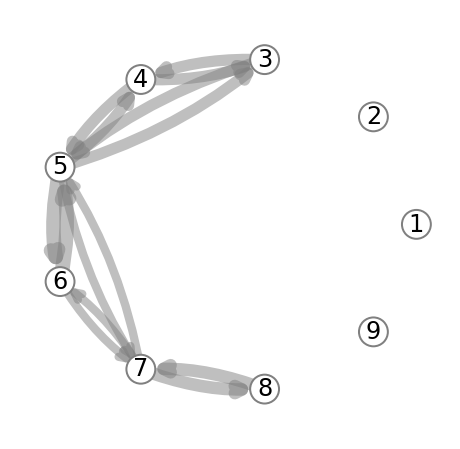

In [50]:
cs.draw_graph(
    in_filter, 
    node_pos=nx.circular_layout(in_filter), 
    node_size_factor=.25, 
    node_border_width=2, 
    edge_width_factor=25, 
    edge_transparency=.5, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=2, 
    figsize='medium'
)

### Function
The ``project_selection_matrix()`` function performs all these steps with just a few parameter inputs. It has two additional features: First, to handle cases where transaction and fact identifiers are not integers from $0$ to $m$ or $n$, that normal form is created (using a function defined in lines 38-40). Second, for transaction matrices the degrees $k$ and selection weights $w$ of transactions are provided.

In [51]:
def project_selection_matrix(
    selections, 
    how, 
    transaction_id='transaction_id', 
    fact_id='fact_id', 
    norm=True, 
    remove_loops=True, 
    symmetrize=True
):
    '''
    Description: Projects a selection matrix to a transaction similarity matrix or a fact 
        co-selection matrix; computes fact attributes; computes cumulative co-selection 
        fractions for matrix filtering.
    
    Inputs:
        selections: Dataframe containing the selection matrix indices and data; must 
            contain a 'weight' column that contains the cell weights.
        how: String that specifies which projection is to be made; must be either 
            'transactions' or 'facts'.
        transaction_id: Name of the column of the dataframe ``selections`` that holds the 
            identifiers of the transactions selecting facts.
        fact_id: Name of the column of the dataframe ``selections`` that holds the 
            identifiers of the facts getting selected in transactions.
        norm: Boolean parameter specifying if matrix normalization should be performed.
        remove_loops: Boolean parameter specifying if the matrix diagonal should be 
            removed; if False, loops will be included in computing cumulative 
            co-selection fractions.
        symmetrize: Boolean parameter specifying if the lower portion of the matrix 
            should be removed.
    
    Output: A dataframe containing the projected matrices (enriched by cumulative 
        fractions in the case of a normalized projection to the fact mode); a dataframe 
        containing matrix-based attributes of transactions or facts (depending on the 
        type of projection)
    '''
    
    # function
    def get_unique(s):
        l = s.unique().tolist()
        return {identifier: index for index, identifier in enumerate(l)}
    
    # map identifiers of transactions and facts to unique integers
    import pandas as pd
    d_transactions_indices = get_unique(selections[transaction_id])
    d_facts_indices = get_unique(selections[fact_id])
    
    # construct selection matrix
    rows = [d_transactions_indices[transaction_id] for transaction_id in selections[transaction_id].values]
    columns = [d_facts_indices[fact_id] for fact_id in selections[fact_id].values]
    cells = selections['weight'].tolist()
    from scipy.sparse import csr_matrix, coo_matrix, triu
    G = coo_matrix((cells, (rows, columns))).tocsr()
    GT = csr_matrix.transpose(G)
    from sklearn.preprocessing import normalize
    GN = normalize(G, norm='l1', axis=1)
    
    # project selection matrix ...
    import numpy as np
    
    # ... to transaction similarity matrix
    if how == 'transactions':
        if norm == True:
            GNT = csr_matrix.transpose(GN)
            H = GN*GNT
        else:
            H = G*GT
        
        # derive transaction attributes dataframe
        H_nodiag = H.tolil()
        H_nodiag.setdiag(values=0)
        
        k = pd.Series([len(i) for i in H_nodiag.data.tolist()])
        w = pd.Series(np.array(H.diagonal()))
        if norm == True:
            w = (1/w).round(4)
        else:
            w = w.round(4)
        
        d_indices_transactions = {index: identifier for identifier, index in d_transactions_indices.items()}
        
        transaction_attributes = pd.concat([pd.Series(d_indices_transactions), k, w], axis=1)
        transaction_attributes.columns = [transaction_id, 'degree', 'weight']
        
        # construct similarities dataframe
        if remove_loops == True:
            H = H.tolil()
            H.setdiag(0)

        if symmetrize == True:
            H = triu(H.tocoo()).tocsr()
        else:
            H = H.tocsr()
        
        transaction_id_from = [d_indices_transactions[index] for index in H.nonzero()[0].tolist()]
        transaction_id_to = [d_indices_transactions[index] for index in H.nonzero()[1].tolist()]
        weight = H.data.tolist()
        
        similarities = pd.concat([pd.Series(transaction_id_from), pd.Series(transaction_id_to), pd.Series(weight)], axis=1)
        similarities.columns = [transaction_id+'_from', transaction_id+'_to', 'similarity']
        
        return similarities, transaction_attributes
    
    # ... to fact co-selection matrix
    if how == 'facts':
        if norm == True:
            I = GT*GN
        else:
            I = GT*G
        
        # derive fact attributes dataframe
        I_nodiag = I.tolil()
        I_nodiag.setdiag(values=0)
        
        k = pd.Series([len(i) for i in I_nodiag.data.tolist()])
        
        d_indices_facts = {index: identifier for identifier, index in d_facts_indices.items()}
        
        if norm == True:
            w = pd.Series(np.squeeze(np.array(I.sum(axis=1)))).round(4)
            a = pd.Series(np.array(I.diagonal())).round(4)
            e = (1-a/w).round(4)
            s = (k/w).round(4)
            
            fact_attributes = pd.concat([pd.Series(d_indices_facts), k, w, a, e, s], axis=1)
            fact_attributes.columns = [fact_id, 'degree', 'weight', 'autocatalysis', 'embeddedness', 'sociability']
            
        else:
            fact_attributes = pd.concat([pd.Series(d_indices_facts), k], axis=1)
            fact_attributes.columns = [fact_id, 'degree']
        
        # construct co-selections dataframe with cumulative co-selection fractions
        if remove_loops == True:
            I = I.tolil()
            I.setdiag(0)
        
        if symmetrize == True:
            I = triu(I.tocoo()).tocsr()
        else:
            I = I.tocsr()
                
        fact_id_from = [d_indices_facts[index] for index in I.nonzero()[0].tolist()]
        fact_id_to = [d_indices_facts[index] for index in I.nonzero()[1].tolist()]
        weight = I.data.tolist()
        
        co_selections = pd.concat([pd.Series(fact_id_from), pd.Series(fact_id_to), pd.Series(weight)], axis=1)
        co_selections.columns = [fact_id+'_from', fact_id+'_to', 'weight']
        
        co_selections_cumfrac = co_selections.copy()
        co_selections_cumfrac.index = co_selections_cumfrac.weight
        co_selections_cumfrac = co_selections_cumfrac['weight'].groupby(co_selections_cumfrac.index).sum()
        co_selections_cumfrac = co_selections_cumfrac.sort_index(ascending=False)
        co_selections_cumfrac = co_selections_cumfrac.cumsum()/sum(co_selections_cumfrac)
        co_selections_cumfrac = co_selections_cumfrac.round(4)
        co_selections_cumfrac.rename('cumfrac', inplace=True)
        
        co_selections = pd.merge(left=co_selections, right=co_selections_cumfrac, left_on='weight', right_on=co_selections_cumfrac.index)
        
        return co_selections, fact_attributes

As part of the ``compsoc`` library, we can call this function, e.g., to compare the fact co-selection matrices with and without normalization:

In [52]:
with_normalization, _ = cs.project_selection_matrix(
    selections=selections, 
    how='facts', 
    norm=True, 
    remove_loops=False, 
    symmetrize=False
)

In [53]:
pd.pivot_table(
    data=with_normalization, 
    values='weight', 
    index='fact_id_from', 
    columns='fact_id_to'
).round(4)

fact_id_to,0,1,2,3,4,5,6,7,8
fact_id_from,,,,,,,,,
0,0.2,0.2,0.20,0.20,0.2000,NaN,NaN,NaN,NaN
1,0.2,0.2,0.20,0.20,0.2000,NaN,NaN,NaN,NaN
2,0.2,0.2,0.45,0.45,0.4500,0.2500,NaN,NaN,NaN
3,0.2,0.2,0.45,0.45,0.4500,0.2500,NaN,NaN,NaN
4,0.2,0.2,0.45,0.45,0.7833,0.5833,0.3333,NaN,NaN
5,NaN,NaN,0.25,0.25,0.5833,0.5833,0.3333,NaN,NaN
6,NaN,NaN,NaN,NaN,0.3333,0.3333,0.8333,0.5,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,0.5000,0.5,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [54]:
without_normalization, _ = cs.project_selection_matrix(
    selections=selections, 
    how='facts', 
    norm=False, 
    remove_loops=False, 
    symmetrize=False
)

In [55]:
pd.pivot_table(
    data=without_normalization, 
    values='weight', 
    index='fact_id_from', 
    columns='fact_id_to'
)

fact_id_to,0,1,2,3,4,5,6,7,8
fact_id_from,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,1.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN
3,1.0,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN
4,1.0,1.0,2.0,2.0,3.0,2.0,1.0,NaN,NaN
5,NaN,NaN,1.0,1.0,2.0,2.0,1.0,NaN,NaN
6,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Multiplex data
As we have just seen, the weight of edges in meaning structures is intimately related to the number of transactions and the number of selections per transaction in a field. If we simply filter co-selections in a field (using weights or cumulative fractions), we may unwillingly punish a subfield that is not as voluminous or exhibits a different style of behavior as another subfield. For example, an academic field may harbor subfields of different size (different number of publications) and with different publication practices (different conventions of how many references to cite in a publication). In such cases, it is advised to use multiplex data, i.e., to use one network layer per subfield. These layers are the different **domains** of social life. Each domain has its own **type of tie**, but domains can - and typically do - overlap in terms of facts. It is a beauty of the matrix formalism that a mapping of transactions to domains translates to a separate type of tie per domain in the meaning structure (see figure 1).

### Function

The ``meaning_structures()`` function is a software wrapper around the ``project_selection_matrix()`` function that is tailored to creating multi-layer meaning structures (it is restricted to projecting selection matrices to the fact mode). The ``multiplex`` parameter decides if multi-layer fact matrices are created. If ``multiplex=True``, a ``transactions`` dataframe must be provided that maps a ``transaction_id`` to a ``domain_id``. Consult the description below for details, e.g., about outputs:

In [56]:
def meaning_structures(
    selections, 
    transaction_id, 
    fact_id, 
    multiplex=False, 
    transactions=None, 
    domain_id=None, 
    facts=None, 
    norm=True, 
    remove_loops=True, 
    symmetrize=True
):
    '''
    Description: Projects a selection matrix to (multiplex) co-selection matrix.
    
    Inputs:
        selections: Dataframe containing the selection matrix indices and data; must 
            contain a 'weight' column that contains the cell weights.
        transaction_id: Name of the column of the dataframe ``selections`` that holds the 
            identifiers of the transactions selecting facts.
        fact_id: Name of the column of the dataframe ``selections`` that holds the 
            identifiers of the facts getting selected in transactions.
        multiplex: Boolean parameter specifying if selections occurr in multiple domains; 
            set to False by default.
        transactions: Dataframe containing the ``transaction_id`` identifiers of the 
            ``selections`` dataframe; must be specified if ``multiplex=True``; set to None 
            by default.
        domain_id: Name of the column of the dataframe ``transactions`` that holds the 
            identifiers of the domains the transactions belong to; must be an integer from 
            0 to d where d is the number of domains; must be specified if 
            ``multiplex=True``; set to None by default.
        facts: Dataframe containing the ``fact_id`` identifiers of the ``selections`` 
            dataframe; if specified, it will be enriched by fact attributes; set to None 
            by default.
        norm: Boolean parameter specifying if matrix normalization should be performed.
        remove_loops: Boolean parameter specifying if the matrix diagonal should be 
            removed; if False, loops will be included in computing cumulative 
            co-selection fractions.
        symmetrize: Boolean parameter specifying if the lower portion of the matrix 
            should be removed.
    
    Output: At least two dataframes will be returned: first, a dataframe containing the 
        co-selection matrix independent of domain; second, a dataframe containing fact 
        attributes (if no ``facts`` dataframe is provided), or an enriched ``facts`` 
        dataframe (if one is provided), independent of domain. When ``multiplex=True`` 
        two additional dataframes will be returned: third, a dataframe containing the 
        co-selection matrix for domains; fourth, a list of dataframes containing fact 
        attributes (if no ``facts`` dataframe is provided), or a list of enriched 
        ``facts`` dataframes (if a ``facts`` dataframe is provided), for domains.
    '''
    
    if multiplex == True:
        if transactions is None:
            print('A transactions dataframe must be specified.')
        else:
            if domain_id is None:
                print('The domain identifier for the transactions dataframe must be specified.')
            else:
                if domain_id not in transactions.columns:
                    print('The specified domain identifier is not a column in the transactions dataframe.')
                else:
                    domain_ids = set(transactions[domain_id])
                    if (len(domain_ids) > 1) & (min(domain_ids) == 0) & (max(domain_ids) == len(domain_ids)-1):
                        
                        # co-selections and fact attributes dataframes independent of domain
                        co_selections, fact_attributes = project_selection_matrix(selections=selections, how='facts', transaction_id=transaction_id, fact_id=fact_id, norm=norm, remove_loops=remove_loops, symmetrize=symmetrize)
                        
                        # co-selections and fact attributes dataframes for domains
                        co_selections_domain = pd.DataFrame(columns=[fact_id+'_from', fact_id+'_to', 'weight', 'cumfrac', domain_id])
                        fact_attributes_domain = []
                        facts_enriched_domain = []
                        for identifier in set(transactions[domain_id]):
                            df = selections[selections[transaction_id].isin(transactions[transactions[domain_id] == identifier][transaction_id])]
                            df_co_selections, df_fact_attributes = project_selection_matrix(selections=df, how='facts', transaction_id=transaction_id, fact_id=fact_id, norm=norm, remove_loops=remove_loops, symmetrize=symmetrize)
                            df_co_selections[domain_id] = identifier
                            co_selections_domain = pd.concat([co_selections_domain, df_co_selections])
                            if facts is None:
                                fact_attributes_domain.append(df_fact_attributes)
                            else:
                                df_facts_enriched = pd.merge(left=facts, right=df_fact_attributes, on=fact_id, how='left')
                                facts_enriched_domain.append(df_facts_enriched)
                        co_selections_domain.reset_index(drop=True, inplace=True)
                        if facts is None:
                            return co_selections, fact_attributes, co_selections_domain, fact_attributes_domain
                        else:
                            facts_enriched = pd.merge(left=facts, right=fact_attributes, on=fact_id, how='left')
                            
                            return co_selections, facts_enriched, co_selections_domain, facts_enriched_domain
                    else:
                        print('The specified domain identifier does not contain multiple domains or domains are not coded as integers starting with zero.')
    else:
        
        # co-selections and fact attributes dataframes independent of domain
        co_selections, fact_attributes = project_selection_matrix(selections=selections, how='facts', transaction_id=transaction_id, fact_id=fact_id, norm=norm, remove_loops=remove_loops, symmetrize=symmetrize)
        
        if facts is None:
            return co_selections, fact_attributes
        else:
            facts_enriched = pd.merge(left=facts, right=fact_attributes, on=fact_id, how='left')
            
            return co_selections, facts_enriched

Now we want to visualize the relationship of 

The ``transactions`` dataframe of the toy example contains the necessary mapping of ``transaction_id`` to ``domain_id``. To use those domain identifiers for coloring nodes using the ``draw_graph()`` function, we must create a dictionary with `transaction_id``

[colorbrewer2.org](https://colorbrewer2.org/) is a great dource of color advice for cartography:

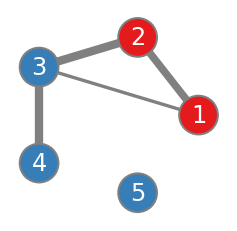

In [57]:
cs.draw_graph(
    hn, 
    node_pos=nx.circular_layout(hn), 
    node_size_factor=.25, 
    node_color=cs.id_to_vertex_property(transactions['domain_id'], {0: '#e41a1c', 1: '#377eb8'}), 
    node_border_width=2, 
    edge_width_factor=50, 
    labels='text', 
    font_size_factor=2, 
    font_color='white', 
    figsize='small', 
    margins=.2
)

Now we can call the ``meaning_structures()`` function to create multiplex fact matrix:

In [58]:
_, facts_enriched, co_selections_domain, _ = cs.meaning_structures(
    selections=selections, 
    transaction_id='transaction_id', 
    fact_id='fact_id', 
    multiplex=True, 
    transactions=transactions, 
    domain_id='domain_id', 
    facts=facts, 
    symmetrize=False
)

In [59]:
in_domain = cs.construct_graph(
    directed=True, 
    multiplex=True, 
    graph_name='IN_domain', 
    node_list=facts, 
    edge_list=co_selections_domain[['fact_id_from', 'fact_id_to', 'weight', 'domain_id']], 
    node_label='fact'
)

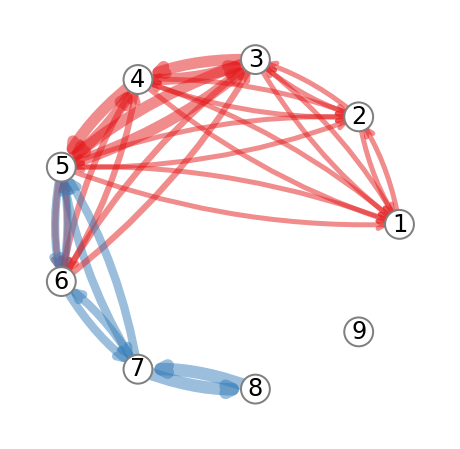

In [60]:
cs.draw_graph(
    in_domain, 
    node_pos=nx.circular_layout(in_domain), 
    node_size_factor=.25, 
    node_border_width=2, 
    edge_width_factor=25, 
    edge_transparency=.5, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=2, 
    figsize='medium'
)